This notebook shows the process used for making a model of SN2011fe. While I used some specific parameters, they can easily be changed to suit anyone's needs.

In [1]:
#Imports
%matplotlib inline

import simsurvey
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck15, z_at_value
import astropy.units as u
import sncosmo
import pandas as pd
from path import Path
from astropy.io import ascii
import extinction as ext #Package to easily calculate extinction at a given wavelength
from astropy.table import vstack
from scipy import interpolate
import mmap

#Global values
master_loc = Path('/Users/terwelj/Projects/Late-time_signals/simsurvey')
z_11fe = z_at_value(Planck15.comoving_distance, 6.4*u.Mpc) #From Shappee & Stanek 2011 (Cepheid measurement)

First, lets define the functions that are used for making the model

In [2]:
#Given a dataframe with spectra to load, load and process them into timeseriessource model-ready arrays
def load_model_spectra(spec_list, spec_loc, zhost, wlchoice, name, time_spline_degree=3):
    '''
    Attributes:
    - spec_list: list of spectra to use
    - spec_loc:  spectra folder location
    - zhost:     host redshift to correct for (returns model at a distance of 10pc)
    - wlchoice:  wl array from which spectrum to use in the final model, other spectra are interpolated if needed
                 alternatively if an array is given, interpolate spectra to match this array
    - name:      model name
    - time_spline_degree: spline order of time interpolation in the model
    Returns:
    - source: A TimeSeriesSource instance that can be used as the model
    '''
    #Set initial values
    nr_spec = len(spec_list)
    specs = [0] * nr_spec
    phases = spec_list['Phase (days)'].to_numpy(dtype='float')
    #Update these to find the wl region covered by all spectra
    wl_min = 0
    wl_max = 0
    #Get the correct magnitudes at the spec phases
    correct_mags, bands, magsys = get_mags(phases, zhost)
    #Load and pre process the data 1 spectrum at a time
    for i in range(nr_spec):
        spec = ascii.read(spec_loc+spec_list['Ascii file'].iloc[i])
        #These spectra have no reported uncertainties --> Assume a value (Needed for the rebinning, using 0)
        specs[i] = sncosmo.Spectrum(spec.columns[0], spec.columns[1], np.zeros_like(spec.columns[0]))
        if ((wl_min == 0) | (wl_min < spec.columns[0][0])):
            wl_min = spec.columns[0][0]
        if ((wl_max == 0) | (wl_max > spec.columns[0][-1])):
            wl_max = spec.columns[0][-1]
        #Flux calibrate & deredden the data if needed
        if np.isnan(spec_list['Flux Calibrated By'].iloc[i]):
            calib_flux(specs[i], correct_mags[i], bands[i], magsys[i])
        if spec_list['Extinction-Corrected'].iloc[i] != True:
            deredden(specs[i], zhost)
    #Choose wl to be used in the model, and adapt all spectra to this (observer frame, go to rest frame later)
    if type(wlchoice)==int:
        wl = specs[wlchoice].wave
        wl = wl[(wl>=wl_min)&(wl<=wl_max)]
    else: #assume wlchoice is a given list/array of wls, Check if it falls inside the wl region of these spectra
        if wlchoice[0]<wl_min:
            print('⚠️: requested blue edge beyond the spectra blue edge!')
        if wlchoice[-1]>wl_max:
            print('⚠️: requested red edge beyond the spectra red edge!')
        wl = wlchoice
    flux_mat = np.zeros((nr_spec, len(wl)))
    for i in range(nr_spec):
        flux_mat[i] = specs[i].rebin(wl).flux
    #Move sn to 10pc (don't have to worry about it during distance setting in the simulation)
    flux_mat *= 10**(0.4*Planck15.distmod(zhost).value)
    #Correct wl & phases for redshift, so that we have them in rest frame instead of observer frame
    wl /= 1+zhost
    phases /= 1+zhost
    #print some information over what range of z can be used to cover all 3 ZTF filters
    if wl[-1] < 8863.74:
        print('Warning, ztfi filter not fully covered: max wl = {}, needs to be 8863.74'.format(wl[-1]))
    print('Minimum wl = {} --> To still fully cover ztfg, max z = {} with ztfg, max z = {} with ztfg_mod'.format(
            wl[0], 3676.0/wl[0]-1, 4091.0/wl[0]-1))
    #Make a TimeSeriesSource with the desired spline degree
    #Using a quick hack for now until the desired sncosmo functions are changed in an update
    #return sncosmo.TimeSeriesSource(phases, wl, flux_mat, name=name, time_spline_degree=time_spline_degree)
    source = sncosmo.TimeSeriesSource(phases, wl, flux_mat, name=name)
    if time_spline_degree != 3: #Keeping wl direction at 3
        #Using the same function as would be used inside TimeSeriesSource
        source._model_flux = interpolate.RectBivariateSpline(phases, wl, flux_mat, kx=time_spline_degree)
    return source

def read_filter(name):
    '''
    Function used to create custom filters for those that are not standard in sncosmo
    Attributes:
    - name: Name of the filter
    Returns:
    - wl:     Wavelength array in A
    - transm: Transmission array, same length as wl
    '''
    file_loc = '/Users/terwelj/Projects/Late-time_signals/filters.txt'
    with open(file_loc) as f:
        s = mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ)
        s.seek(s.find(b' '+name+b' ')-11)
        print(s.readline().decode('ASCII'))
        wl = []
        transm = []
        while 1==1:
            newline = s.readline().decode('ASCII') #decode bytes like to regular string
            if 'Filter' in newline:
                break
            else:
                wl.append(newline.split()[0])
                transm.append(newline.split()[1])
    return np.array(wl).astype(np.float), np.array(transm).astype(np.float)

#Flux calibration function, works without having to return anything as it updates things in-place
def calib_flux(spec, correct_mags, bands, magsys):
    mags_uncalib = spec.bandmag(bands, magsys=magsys)
    correction = correct_mags - mags_uncalib
    spec.flux = np.average(10**(-0.4*correction)) * spec.flux
    return

#Deredden spectrum, works without having to return anything as it updates things in-place
def deredden(spec, hostz):
    #MW extinction from sfd89 maps at 11fe location: Av_MW = 0.029 E(B-V) = 0.009
    #Patat et al. 2013: Very clean environment --> host reddening negligible
    #E(B-V) total = 0.014, Av total = 0.04 total extinction (not split up between host, mw)
    Rv = 3.1
    Av = 0.04
    spec.flux = ext.remove(ext.ccm89(spec.wave, Av, Rv), spec.flux)
    return

def get_mags(phases, hostz):
    '''
    Calculate the brightness in bands for given phases using different methods
    
    Up to +45 days: take from salt2 fit (also gives max)
    Get salt fit points for last days 43, 44, 45 as anchor
    Using anchor: interpolate
    600+ days: Shappee 2016 LBT bessel R mags in vega system
    
    Attributes:
    - phases: list of phases to interpolate magnitudes for
    - hostz:  redshift of the host
    
    Returns:
    - pmags:  magnitudes at each phase
    - bands:  bands for each given magnitude
    - magsys: magsystem for each given magnitude (Vega / AB)
    '''
    lc_r = ascii.read(master_loc / 'SN2011fe_ptf_r.dat')
    lc_g = ascii.read(master_loc / 'SN2011fe_ptf_g.dat')
    lc_R = ascii.read(master_loc / 'SN2011fe_Shappee_LBT_R.dat')
    #salt2 part
    res, model = salt2_lc_fit(lc_g.copy(), lc_r.copy(), hostz, 55814.3, 45) #55814.3 = initial guess of t0
    #Get anchors to connect to interpolation part
    t0 = res.parameters[res.param_names.index('t0')]
    t_anchor = t0+np.array([43, 44, 45])
    g_anchor = model.bandmag('ptf48g', 'vega', t_anchor)
    r_anchor = model.bandmag('ptf48r', 'vega', t_anchor)
    #Interpolation part
    g_interpf, max_phase_g = interp_cubic(lc_g[lc_g.columns[0]>t0+45], g_anchor, t_anchor)
    r_interpf, max_phase_r = interp_cubic(lc_r[lc_r.columns[0]>t0+45], r_anchor, t_anchor)
    R_interpf, max_phase_R = interp_Shappee(lc_R)
    #change max phases from mjd to phase
    max_phase_g -= t0
    max_phase_r -= t0
    max_phase_R -= t0
    #Get the magnitudes at the requested times
    pmag_45_min_g = model.bandmag('ztfg', 'ab', t0+phases[phases<45])
    pmag_45_min_r = model.bandmag('ztfr', 'ab', t0+phases[phases<45])
    pmag_45_plus_g = g_interpf(t0+phases[(phases>=45)&(phases<max_phase_g)])
    pmag_45_plus_r = r_interpf(t0+phases[(phases>=45)&(phases<max_phase_r)])
    pmag_R = R_interpf(t0+phases[(phases>=max_phase_r)&(phases<max_phase_R)])
    #format result & return
    pmags = [0]*len(phases)
    bands = [0]*len(phases)
    magsys = [0]*len(phases)
    for i in range(len(phases)):
        if phases[i] < 45: #In the salt fit part
            pmags[i] = [pmag_45_min_g[i], pmag_45_min_r[i]]
            bands[i] = ['ztfg', 'ztfr']
            magsys[i] = 'ab'
        elif phases[i] < max_phase_g: #In the interpolation part with both ptfg & ptfr
            pmags[i] = [pmag_45_plus_g[i-len(pmag_45_min_g)], pmag_45_plus_r[i-len(pmag_45_min_r)]]
            bands[i] = ['ptf48g', 'ptf48r']
            magsys[i] = 'vega'
        elif phases[i] < max_phase_r: #In the interpolation part with only ptfr
            pmags[i] = [pmag_45_plus_r[i-len(pmag_45_min_r)]]
            bands[i] = ['ptf48r']
            magsys[i] = 'vega'
        elif phases[i] < max_phase_R: #In the late time part Shappee data interpolation part
            pmags[i] = [pmag_R[i-len(pmag_45_min_r)-len(pmag_45_plus_r)]]
            bands[i] = ['bessellr']
            magsys[i] = 'vega'
        else:
            print('ERROR: failed to find mag for phase {}'.format(phases[i]))
    return pmags, bands, magsys

def salt2_lc_fit(g, r, hostz, t0, phase_max):
    '''
    Fit a salt2 lightcurve
    '''
    #Change tables into correct format for salt2
    r['band']=['ztfr']*len(r.columns[0])
    r['zpsys']=['ab']*len(r.columns[0])
    r.rename_column('counts', 'flux')
    r.rename_column('dcounts', 'flux_err')
    g['band']=['ztfg']*len(g.columns[0])
    g['zpsys']=['ab']*len(g.columns[0])
    g.rename_column('counts', 'flux')
    g.rename_column('dcounts', 'flux_err')
    comb = vstack([r, g])
    #make & fit the model
    model = sncosmo.Model('salt2')
    model.set(z=hostz)
    return sncosmo.fit_lc(comb[comb.columns[0]<t0+phase_max], model, ['x0', 'x1', 'c', 't0'])

def interp_Shappee(lc):
    mjd, flux, dflux, zp = bin_dat(lc.columns[0], 10**(-0.4*lc.columns[4]),
                                   10**(-0.4*lc.columns[4])*np.log(10)/2.5, lc.columns[1], 30)
    mag = -2.5*np.log10(flux)
    return interpolate.interp1d(mjd, mag, kind='cubic'), mjd[-1]

def interp_cubic(lc, anchor, t_anchor):
    #bin data
    mjd, flux, dflux, zp = bin_dat(lc.columns[0], lc.columns[1], lc.columns[2], lc.columns[3], 25)
    #Select good values & go to mag space (AB mags)
    good_vals = flux > 3*dflux
    mjd = mjd[good_vals]
    zp = zp[good_vals]
    mag = -2.5*np.log10(flux[good_vals]) + zp
    #add anchor
    mjd = np.concatenate((t_anchor, np.array(mjd)))
    mag = np.concatenate((anchor, np.array(mag)))
    #return interpolation function & max_ phase
    return interpolate.interp1d(mjd, mag, kind='cubic'), mjd[-1]

def bin_dat(mjd, counts, counts_err, zp, binsize):
    #Next bin starts at next data point, mjd, zp = avg of binned points
    mjd_binned = []
    counts_binned = []
    counts_err_binned = []
    zp_binned = []
    bin_edge = mjd[0]
    while bin_edge < mjd[-1]:
        this_bin = np.logical_and(mjd < bin_edge+binsize, mjd >= bin_edge)
        mjd_binned.append(np.average(mjd[this_bin]) if len(mjd[this_bin])>0 else bin_edge + binsize/2)
        weights = 1/counts_err[this_bin]**2
        counts_binned.append(sum(counts[this_bin]*weights)/sum(weights))
        counts_err_binned.append(1/np.sqrt(sum(weights)))
        zp_binned.append(np.average(zp[this_bin]))
        #Stop if all points are binned
        if bin_edge+binsize > mjd[-1]:
            break
        bin_edge = mjd[mjd > bin_edge+binsize][0]
    return np.array(mjd_binned), np.array(counts_binned), np.array(counts_err_binned), np.array(zp_binned)

def add_interp_spec(source, time_spline_degree):
    '''
    Special function designed to fill the 500 day gap between observed 11fe spectra
    This function uses set values, and should not be used for anything other than its original intention
    '''
    print('⚠️: THIS FUNCTION IS CUSTOM MADE TO FILL THE 462-963 DAY GAP IN 11fe, DO NOT USE THIS ANYWHERE ELSE!!')
    t_left = 462.3311894843709
    t_right = 963.0568373611264
    mag_left = source.bandmag('ptf48r', 'vega', t_left)
    mag_right = source.bandmag('ptf48r', 'vega', t_right)
    t_needed = np.array([563, 663, 763, 863])
    #mag_needed=np.linspace(mag_left, mag_right, 6)[1:-1]
    mag_needed=np.array([-7.2294, -6.6094, -5.9894, -5.3694])#Taken from eye fit 2 +0.07(See tests at the bottom)
    #Want mag_needed[i] at t_needed[i], but they are at t_have[i]
    y=np.linspace(700, 963, 264)
    mags = source.bandmag('ptf48r', 'vega', y)
    t_have = np.zeros_like(t_needed)
    for i in range(len(mag_needed)):
        mag_diff = np.abs(mags-mag_needed[i])
        t_have[i] = y[np.where(mag_diff==min(mag_diff))[0]][0]
    #Make a new TimeSeriesSource with the interpolated spectra added
    phases = source._phase
    wl = source._wave
    newphases = np.sort(np.concatenate([phases, t_needed]))
    flux_mat = np.zeros((len(newphases), len(wl)))
    for i in range(len(newphases)):
        if newphases[i] in phases:
            flux_mat[i] = source.flux(newphases[i], wl)
        else:
            j = np.where(t_needed == newphases[i])[0]
            flux_mat[i] = source.flux(t_have[j], wl)
    source_new = sncosmo.TimeSeriesSource(newphases, wl, flux_mat, name=source.name+' + interpolated specs')
    source_new._model_flux = interpolate.RectBivariateSpline(newphases, wl, flux_mat, kx=time_spline_degree)
    return source_new

Before we can actually do anything, we need to define some of the bandpasses that are used as they are not standard in sncosmo.

First of all, we need to modify the ZTF g & i filters as they are defined of a large part of the spectrum, with tails on the red and blue sides where the transmission is below 1%. Since the spectra of the model has to be specified over the entire bandpass to calculate the magnitude in that filter, this can become somewhat problematic later on. For this reason, let's define a modified version of these bandpasses where I only keep the part where transmission is above 1%.

Besides this, the PTF48g & PTF48R bandpasses need to be defined as well. These will be used in flux calibrating the model.

In [3]:
#Create own bandpasses: ztfg & ztfi modified with transmission > 0.01, PTF48g & PTF48R defined
ztfg_og = sncosmo.get_bandpass('ztfg')
ztfg_mod = sncosmo.Bandpass(ztfg_og.wave[ztfg_og.trans>0.01], ztfg_og.trans[ztfg_og.trans>0.01], name='ztfg_mod')
sncosmo.register(ztfg_mod)

ztfi_og = sncosmo.get_bandpass('ztfi')
ztfi_mod = sncosmo.Bandpass(ztfi_og.wave[ztfi_og.trans>0.01], ztfi_og.trans[ztfi_og.trans>0.01], name='ztfi_mod')
sncosmo.register(ztfi_mod)

ptfg_wl, ptfg_trans = read_filter(b'PTF48g')
ptfg = sncosmo.Bandpass(ptfg_wl[ptfg_wl>=3635], ptfg_trans[ptfg_wl>=3635]/100, name='ptf48g')
sncosmo.register(ptfg)

ptfR_wl, ptfR_trans = read_filter(b'PTF48R')
ptfR = sncosmo.Bandpass(ptfR_wl, ptfR_trans/100, name='ptf48r')
sncosmo.register(ptfR)

Filter: 1 0 PTF48g PTF CFH12k g 48in

Filter: 1 0 PTF48R PTF CFH12k R Mould 48in



Finally it is time to start making the model. First, we make a list of all spectra we have available, sorted by phase. This is a list of all 184 spectra on WISeREP.

In [4]:
cols = ['Phase (days)', 'Ascii file', 'Source group', 'Extinction-Corrected', 'Flux Calibrated By']
loc = '/Users/terwelj/Projects/Late-time_signals/Spectra/2011fe/'
added_csv1 = pd.read_csv(loc + 'wiserep_spectra1-50.csv', header=0, usecols=cols)
added_csv2 = pd.read_csv(loc + 'wiserep_spectra51-100.csv', header=0, usecols=cols)
added_csv3 = pd.read_csv(loc + 'wiserep_spectra101-150.csv', header=0, usecols=cols)
added_csv4 = pd.read_csv(loc + 'wiserep_spectra151-184.csv', header=0, usecols=cols)
added_csv = pd.concat([added_csv1, added_csv2, added_csv3, added_csv4], ignore_index=True)

We will select manually which spectra we want to use in our model by making a list of indices corresponding to these spectra.

There is a possibility that the spectra we chose come from different instruments, and have differently spaced wavelength ranges. For this reason we need to choose a specific spectrum whose wavelength spacing will be used. All spectra will be rebinned to follow this wavelength spacing. In this case I chose index[3], which is spectrum 8, a snfactory spectrum.

For the last couple of spectra, we need to slightly adjust our approach. The first reason for this is that the standard cubic time interpolation fails as part of the interpolated spectrum becomes negative. For this reason we specify time_spline_degree=1 a.k.a. linear time interpolation. The cubic and linear time interpolated parts of the model are separate instances of sncosmo.TimeSeriesSource() called source_cub and source_line, repectively here.

The second adjustment is to correct a newly made error in the linear time interpolated model. Since the spectra are flux density versus wavelength, and we interpolate linearly, it follows that the flux decreases linearly in the model. Since the connection between flux and magnitude is logarithmic, the resulting light curve will not decrease linearly in mag space. This is especially noticable in the 500+ day gap between spectra used to make this part of the model as there is no spectrum covering the required wavelength range in during these phases. The solution is making these spectra ourselves: First, use the model to interpolate a spectrum at phase X, and calculate that it should have been this bright at phase Y. Then, make a new model with the interpolated spectrum at phase Y added to the observed spectra. The result is a model whose light curve looks more linear in mag space. This is done here using the add_interp_spec() function, which is tailored specifically to this using 4 interpolated spectra evenly spaced in time.

In [5]:
#Choose which list of spectra will be used for the base source, and which spectra will give the base wl range
i_needed = [1, 3, 5, 8, 10, 17, 23, 27, 33, 40, 43, 46, 49, 52, 54, 56, 59, 60, 63, 69, 73, 75, 78, 83, 86, 88, 91,
            93, 95, 97, 98, 101, 108, 109, 112, 114, 116, 117, 120, 121, 122, 123, 127, 128, 129, 130, 132, 133,
            134, 135, 139, 140, 143, 145, 148, 150, 154, 159, 163, 165, 167, 172, 177, 179, 180, 182, 183]
wl_choice = 3

source_cub = load_model_spectra(added_csv.iloc[i_needed[:-3]], loc, z_11fe, wl_choice, name='11fe_cubic_time')
wls = source_cub._wave * (1+z_11fe)

source_lin = load_model_spectra(added_csv.iloc[i_needed[-4:]], loc, z_11fe, wls, name='11fe_linear_time',
                                time_spline_degree=1)

source_lin_interp = add_interp_spec(source_lin, 1)

Minimum wl = 3576.7258911750937 --> To still fully cover ztfg, max z = 0.02775558201701922 with ztfg, max z = 0.14378348368651395 with ztfg_mod
Minimum wl = 3576.7258911750937 --> To still fully cover ztfg, max z = 0.02775558201701922 with ztfg, max z = 0.14378348368651395 with ztfg_mod
⚠️: THIS FUNCTION IS CUSTOM MADE TO FILL THE 462-963 DAY GAP IN 11fe, DO NOT USE THIS ANYWHERE ELSE!!


Of course it would be nice to save the newly made model so that we can just load it instead of having to remake the entire thing the next time. You can do it any way you like, below is how I have done it. Note that I save the different parts of the model separately, as linear time interpolation needs to be specifically stated.

In [ ]:
#Save the base source so it can be loaded in later instead of having to be remade
def save_TimeSeriesSource(source, saveloc, name):
    wls = source._wave
    phases = source._phase
    flux = source._flux(phases, wls)
    pd_source = pd.DataFrame(flux, index=phases, columns=wls)
    pd_source.to_csv(saveloc / name)
    return

#Load the base source
def load_TimeSeriesSource(loc, name, time_spline_degree=3):
    pd_source = pd.read_csv(loc, header=0, index_col=0)
    wl = pd_source.columns.values.astype('float64')
    if wl[-1] < 8863.74:
        print('Warning, ztfi filter not fully covered: max wl = {}, needs to be 8863.74'.format(wl[-1]))
    print('Minimum wl = {} --> To still fully cover ztfg, max z = {} with ztfg, max z = {} with ztfg_mod'.format(
            wl[0], 3676.0/wl[0]-1, 4091.0/wl[0]-1))
    source = sncosmo.TimeSeriesSource(pd_source.index.values, wl, pd_source.values, name=name)
    if time_spline_degree != 3:
        source._model_flux = interpolate.RectBivariateSpline(pd_source.index.values, wl, pd_source.values,
                                                             kx=time_spline_degree)
    return source

In [ ]:
#Saving
save_TimeSeriesSource(source_cub, master_loc, '11fe_raw_cubic_peak.csv')
save_TimeSeriesSource(source_lin, master_loc, '11fe_raw_lin_late.csv')
save_TimeSeriesSource(source_lin_interp, master_loc, '11fe_raw_lin_late_interp.csv')

In [ ]:
#Loading
source_cub = load_TimeSeriesSource(master_loc / '11fe_raw_cubic_peak.csv', '11fe_cubic_time')
source_lin_interp = load_TimeSeriesSource(master_loc / '11fe_raw_lin_late_interp.csv',
                                   '11fe_linear_time + interpolated specs', time_spline_degree=1)

Now all we need to do is combine the different parts of our model into one to have a complete, over 1000 day long model for SN2011fe. This is done using the simsurvey.CompoundSource() function. Note however that if you want to add an additional feature to the model, you have to do it before putting it in the CompoundSource(). (In my case, I required an additional emission line to be added on top of the model, so I had to combine 3 TimeSeriesSource() objects.)

NOTE: In order to make sure there is no gap between the cubic and linear time interpolation parts of the model, 1 spectrum needs to be in both models (i.e. the end of the first TimeSeriesSource() == the start of the second TimeSeriesSource()). This exact phase is ill-defined in the resulting model, as it is in both parts of the model (mask used in CompoundSource(): minphase <= phase <= maxphase) but the chance to get this exact phase during a simulation is low enough that this can be ingored. (For ZTF: assuming 3 day cadence with 3 filters = 1/86400 chance if the ill-defined phase lasts 1 second. Machine precision goes beyond this, making the chance even smaller.)

In [6]:
source_full = simsurvey.CompoundSource((source_cub, source_lin_interp), name='11fe full')

Something that I forgot to mention, but is vitally important, is exactly what this model is. This is a model with the following aspects:

- A model of a normal SN Ia
- Based on observations of SN2011fe
- Phases from -16 days to 1016 days, phase=0 at peak
- Split into a cubic and linear time interpolation parts
- Used interpolated spectra to improve interpolation in a large gap between observed spectra
- The model puts the SN to be at 10pc from Earth (without rescaling, band magnitudes are absolute Magnitude)
- The model is dereddened (No dust between SN and observer)
- All distance effects are taken care of (redshift, time dilation, dimming due to distance (see above))

Now that we have the full model, it might be nice to see what its lightcurve looks like in the ztf filters. The specific model shown here is tailored to look best in ztfr. As a result, some odd deviations can be seen in ztfg and ztfi, especially at later times. As can be seen, There are many spectra at early times around peak, but the time between oberved spectra becomes larger at later times.

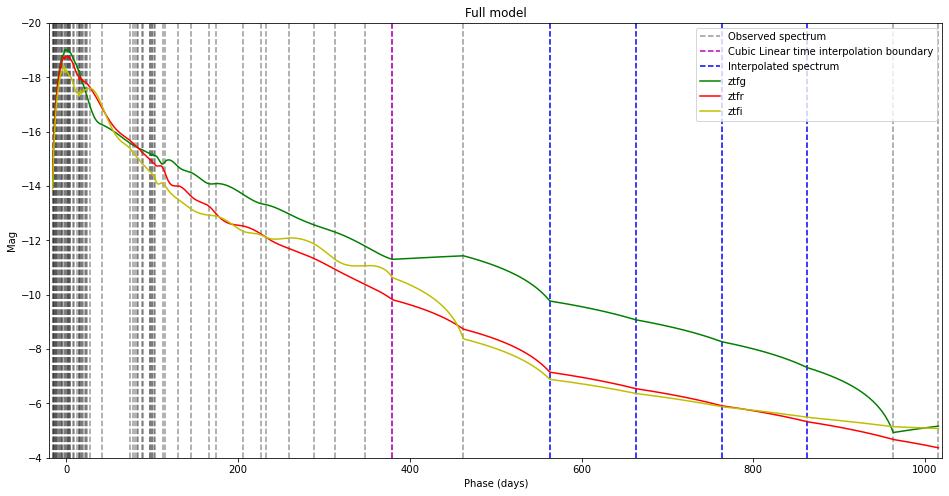

In [7]:
phases_cub = source_cub._phase
phases_lin = source_lin._phase
phases_lin_interp = source_lin_interp._phase
wls_model = source_cub._wave

x = np.linspace(phases_cub.min(), phases_lin_interp.max(), 2000)
count = 0

fig = plt.figure(figsize=(16,8))
for phase in phases_cub:
    if count == 0:
        count += 1
        plt.axvline(phase, ls='--', color='k', label='Observed spectrum', alpha=0.4)
    else:
        plt.axvline(phase, ls='--', color='k', alpha=0.4)
for phase in phases_lin_interp:
    if phase in phases_lin:
        if count == 1:
            count += 1
            plt.axvline(phase, ls='--', color='m', label='Cubic Linear time interpolation boundary')
        else:
            plt.axvline(phase, ls='--', color='k', alpha = 0.4)
    elif count == 2:
        count += 1
        plt.axvline(phase, ls='--', color='b', label='Interpolated spectrum')
    else:
        plt.axvline(phase, ls='--', color='b')
plt.plot(x, source_full.bandmag('ztfg_mod', 'ab', x), 'g', label='ztfg')
plt.plot(x, source_full.bandmag('ztfr', 'ab', x), 'r', label='ztfr')
plt.plot(x, source_full.bandmag('ztfi_mod', 'ab', x), 'y', label='ztfi')
plt.ylim(-4,-20)
plt.xlim(-20,1020)
plt.legend(loc='upper right')
plt.xlabel('Phase (days)')
plt.ylabel('Mag')
plt.title('Full model')
plt.show()

It might be a good idea to show the reason for the change in model making approach at late times. To do this, lets make a regular cubic time interpolation version of the late times and compare it to the linear versions with and without interpolation. As can be seen, parts of the spectrum become negative resulting in Magnitude errors in all bands when usin cubic time interpolation. Using linear time interpolation with only observed spectra result in a light curve that is clearly not linear. Adding interpolated spectra to the model lessens this to the point that the model light curve can be deemed acceptable.

NOTE: As a direct result of this, it is now possible in sncosmo.TimeSeriesSource() to choose the order of time interpolation. Therefore, the manual change that is done in load_model_spectra() and add_interp_spec() is no longer needed in the newer versions of sncosmo. The result is the same, as the same function is used but internally in sncosmo.

In [8]:
source_cub_late = load_model_spectra(added_csv.iloc[i_needed[-4:]], loc, z_11fe, wls, name='11fe_cubic_time_late')

Minimum wl = 3571.5592564287854 --> To still fully cover ztfg, max z = 0.02924233817014854 with ztfg, max z = 0.14543808635856292 with ztfg_mod


/opt/anaconda3/lib/python3.8/site-packages/sncosmo/models.py:189: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/opt/anaconda3/lib/python3.8/site-packages/sncosmo/models.py:189: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)
/opt/anaconda3/lib/python3.8/site-packages/sncosmo/models.py:189: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)


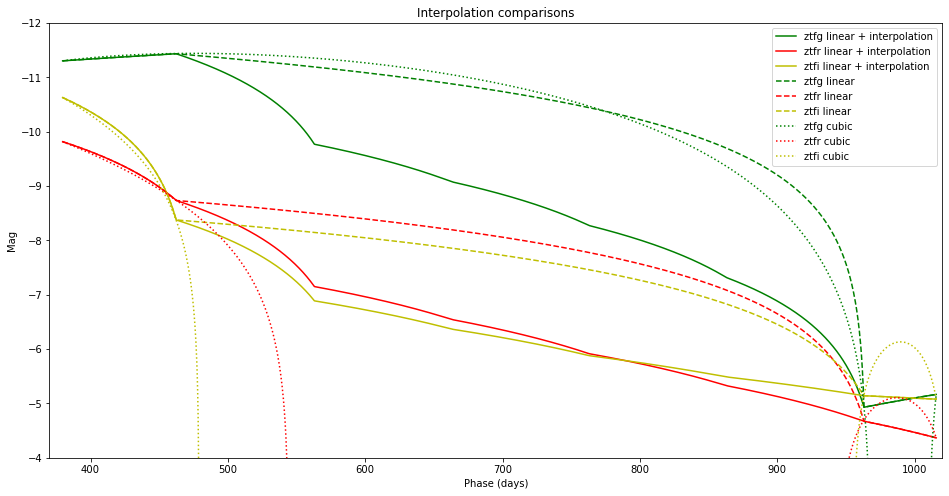

In [9]:
x = np.linspace(phases_lin.min(), phases_lin_interp.max(), 2000)

fig = plt.figure(figsize=(16,8))
plt.plot(x, source_lin_interp.bandmag('ztfg_mod', 'ab', x), 'g', label='ztfg linear + interpolation')
plt.plot(x, source_lin_interp.bandmag('ztfr', 'ab', x), 'r', label='ztfr linear + interpolation')
plt.plot(x, source_lin_interp.bandmag('ztfi_mod', 'ab', x), 'y', label='ztfi linear + interpolation')
plt.plot(x, source_lin.bandmag('ztfg_mod', 'ab', x), 'g--', label='ztfg linear')
plt.plot(x, source_lin.bandmag('ztfr', 'ab', x), 'r--', label='ztfr linear')
plt.plot(x, source_lin.bandmag('ztfi_mod', 'ab', x), 'y--', label='ztfi linear')
plt.plot(x, source_cub_late.bandmag('ztfg_mod', 'ab', x), 'g:', label='ztfg cubic')
plt.plot(x, source_cub_late.bandmag('ztfr', 'ab', x), 'r:', label='ztfr cubic')
plt.plot(x, source_cub_late.bandmag('ztfi_mod', 'ab', x), 'y:', label='ztfi cubic')
plt.ylim(-4,-12)
plt.xlim(370,1020)
plt.legend(loc='upper right')
plt.xlabel('Phase (days)')
plt.ylabel('Mag')
plt.title('Interpolation comparisons')
plt.show()